In [5]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import read_failures_from_file, plots, confidence_interval_binomial
from surface_sim.models import PhenomenologicalDepolNoiseModel
from lomatching import MoMatching

In [6]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [10]:
# INPUTS
FILE_NAME = "20250130_cliffords_modulo_paulis_and_swap.txt"
DISTANCES = [3, 5, 7]
PROBS = [
    0.001,
    0.002,
    0.005,
    0.01,
    0.01165914,
    0.01359356,
    0.01584893,
    0.0184785,
    0.02,
    0.02154435,
    0.02352158,
    0.02511886,
    0.02766324,
    0.02928645,
    0.031,
    0.03253415,
    0.03414549,
    0.03528237,
    0.03826274,
    0.03981072,
    0.04149486,
    0.045,
    0.04641589,
    0.05,
    0.1,
]
NOISE_MODEL = PhenomenologicalDepolNoiseModel
BASES = ["Z", "X"]
FRAMES = ["pre-gate"]
DECODER = MoMatching

PLOTS_DIR = pathlib.Path("plots")

In [11]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()

In [12]:
# GENERATE CIRCUIT
with open(FILE_NAME, "r") as file:
    data = file.read()
circuits = [block.split("TOTAL CIRCUIT:\n")[1] for block in data.split("\n----------\n") if block != ""]
EXPERIMENTS = list(range(len(circuits)))

NUM_FAILURES = np.load("num-failures_phen-noise.npy")
NUM_SAMPLES = np.load("num-samples_phen-noise.npy")

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)

In [13]:
FULL_LOG_PROB = []
done = []
for i, _ in enumerate(EXPERIMENTS):
    if (NUM_SAMPLES[i] == 0).any():
        continue
    FULL_LOG_PROB.append(LOG_PROB[i])
    done.append(i)
FULL_LOG_PROB = np.array(FULL_LOG_PROB)
print("shape:", FULL_LOG_PROB.shape)

shape: (360, 2, 1, 3, 25)


In [14]:
assert len(set(range(len(EXPERIMENTS))).difference(done)) == 0
assert (NUM_SAMPLES != 0).all()

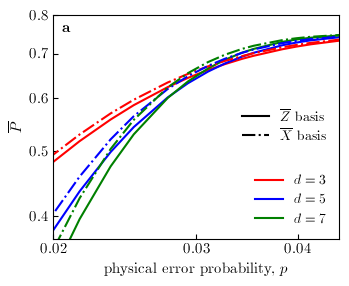

In [15]:
fig, ax = plt.subplots(figsize=cm2inch(8.6, 7))

num_circuits = FULL_LOG_PROB.shape[0]

color_distances_frame = [["red", "blue", "green", "purple"], ["orange", "deepskyblue", "limegreen", "blueviolet"]]
for k, frame in enumerate(FRAMES):
    color_distances = color_distances_frame[k]
    marker_basis = ["s", "*"]
    for j, basis in enumerate(BASES):
        for l, distance in enumerate(DISTANCES):
            ax.plot(PROBS, np.average(FULL_LOG_PROB[:,j,k,l], axis=0), "-" if basis == "Z" else "-.", color=color_distances[l])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("physical error probability, $p$")
ax.set_ylabel("$\\overline{P}$")
ax.set_ylim(3.7e-1, 0.8)
ax.set_xlim(2e-2, 4.5e-2)

xticks = [0.02, 0.03, 0.04]
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = [0.4, 0.5, 0.6, 0.7, 0.8]
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.text(0.0205, 0.755, "\\textbf{a}")

ax.tick_params(direction="in", which="major")
ax.tick_params(direction="in", which="minor")

lines = []
for l, distance in enumerate(DISTANCES):
    line, = ax.plot([], [], color=color_distances[l], linestyle="-", label=f"$d = {distance}$")
    lines.append(line)
legend = ax.legend(handles=lines, loc="lower right", fontsize=10, frameon=False)
ax.add_artist(legend)

line1, = ax.plot([], [], color="black", linestyle="-", label="$\\overline{Z}$ basis")
line2, = ax.plot([], [], color="black", linestyle="-.", label="$\\overline{X}$ basis")
ax.legend(handles=[line1, line2], loc="center right", fontsize=10, frameon=False)

fig.tight_layout(pad=0.30)
fig.savefig(PLOTS_DIR / "threshold_plot_2q-cliffords_phen-depol-noise.pdf", format="pdf")
plt.show()

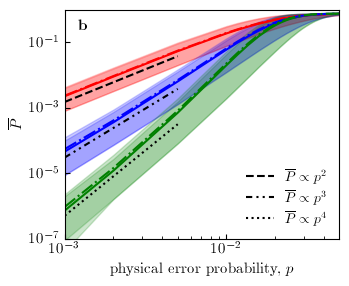

In [16]:
fig, ax = plt.subplots(figsize=cm2inch(8.6, 7))

num_circuits = FULL_LOG_PROB.shape[0]

color_distances_frame = [["red", "blue", "green", "purple"], ["orange", "deepskyblue", "limegreen", "blueviolet"]]
for k, frame in enumerate(FRAMES):
    color_distances = color_distances_frame[k]
    marker_basis = ["s", "*"]
    for j, basis in enumerate(BASES):
        for l, distance in enumerate(DISTANCES):
            ax.plot(PROBS, np.average(FULL_LOG_PROB[:,j,k,l], axis=0), "-" if basis == "Z" else "-.", color=color_distances[l])
            ax.fill_between(PROBS, np.min(FULL_LOG_PROB[:,j,k,l], axis=0), np.max(FULL_LOG_PROB[:,j,k,l], axis=0), color=color_distances[l], alpha=0.2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("physical error probability, $p$")
ax.set_ylabel("$\\overline{P}$")
ax.set_ylim(1e-7, 1.000001)
ax.set_xlim(1e-3, 5e-2)

ax.text(0.0012, 0.25, "\\textbf{b}")

PROBS_ = np.array(PROBS)
PROBS_ = PROBS_[PROBS_ <1e-2]
ax.plot(PROBS_, PROBS_**2 * 1.5e3, "--", color="black", label="$\\overline{P} \\propto p^2$")
ax.plot(PROBS_, PROBS_**3 * 3e4, linestyle=(0, (3, 2, 1, 2, 1, 2)), color="black", label="$\\overline{P} \\propto p^3$")
ax.plot(PROBS_, PROBS_**4 * 5e5, ":", color="black", label="$\\overline{P} \\propto p^4$")
ax.legend(loc="lower right", fontsize=10, frameon=False)

ax.tick_params(direction="in", which="major")
ax.tick_params(direction="in", which="minor")

fig.tight_layout(pad=0.30)
fig.savefig(PLOTS_DIR / "threshold_plot_2q-cliffords_phen-depol-noise_scaling.pdf", format="pdf")
plt.show()

# Get best and worse circuits

In [21]:
worse_pl = {d: (0, None) for d in DISTANCES}
second_worse_pl = {d: (0, None) for d in DISTANCES}
best_pl = {d: (np.inf, None) for d in DISTANCES}
second_best_pl = {d: (np.inf, None) for d in DISTANCES}
for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS):
                    if prob != 2e-3:
                        continue

                    if LOG_PROB[i,j,k,l,m] > worse_pl[distance][0]:
                        worse_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                    elif LOG_PROB[i,j,k,l,m] > second_worse_pl[distance][0]:
                        second_worse_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                        
                    if LOG_PROB[i,j,k,l,m] < best_pl[distance][0]:
                        best_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)
                    elif LOG_PROB[i,j,k,l,m] < second_best_pl[distance][0]:
                        second_best_pl[distance] = (float(LOG_PROB[i,j,k,l,m]), i)

In [22]:
print(worse_pl)
print(second_worse_pl)
print(best_pl)
print(second_best_pl)

{3: (0.016920601148260724, 248), 5: (0.0008764193292843939, 255), 7: (3.616429389625266e-05, 255)}
{3: (0.01636096763648251, 255), 5: (0.0007718072450655139, 281), 7: (3.0277297662884197e-05, 281)}
{3: (0.003230903921948698, 0), 5: (7.269354022600776e-05, 0), 7: (1.6040984294952548e-06, 0)}
{3: (0.004055967245013783, 74), 5: (0.00010169181836638018, 74), 7: (1.6095669036845508e-06, 0)}


In [23]:
for distance in DISTANCES:
    print(distance, worse_pl[distance][0] / best_pl[distance][0])

3 5.237110591037067
5 12.056357780341466
7 22.544934420035624


In [24]:
with open(FILE_NAME, "r") as file:
    data = file.read()
circuits = [block.split("TOTAL CIRCUIT:\n")[1] for block in data.split("\n----------\n") if block != ""]
labelled_circuits_z = {}
labelled_circuits_x = {}
for k, circuit in enumerate(circuits):
    labelled_circuits_z[k] = circuit
    labelled_circuits_x[k] = circuit.replace("R 0 1", "RX 0 1").replace("M 0 1", "MX 0 1")
    
EXPERIMENTS = list(range(len(labelled_circuits_z)))
assert len(EXPERIMENTS) == 360

In [25]:
ind = 255
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 14
R 0 1
TICK
S 0
I 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
CX 0 1
TICK
S 0
I 1
TICK
H 0
I 1
TICK
S 0
I 1
TICK
S 0
I 1
TICK
CX 1 0
TICK
H 0
I 1
TICK
CX 0 1
TICK
S 0
I 1
TICK
H 0
I 1
TICK
S 0
I 1
TICK
M 0 1


In [26]:
ind = 0
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 0
R 0 1
TICK
M 0 1


In [27]:
ind = 74
print("depth =", len(circuits[ind].split("TICK")) - 2)
print(circuits[ind])

depth = 2
R 0 1
TICK
H 0 1
TICK
H 0 1
TICK
M 0 1
